In [1]:
import numpy as np
import tifffile
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d, median_filter
from skimage.morphology import dilation, disk

# **dF/F₀ Normalization**

Calcium imaging provides a window into the activity of neurons, but raw fluorescence signals are often influenced by baseline fluctuations and background activity from the surrounding tissue. To make these signals interpretable, we will compute dF/F₀, which represents the fractional change in fluorescence relative to a resting baseline.

In this module, we will start by using pre-defined cell and neuropil masks to walk through the core steps for computing dF/F₀ from a single-cell calcium imaging dataset. Then we will see how to make our own neuropil mask using available cell mask.

## **Neuropil Subtraction**

This section focuses on computing the corrected calcium trace. The goal is to produce a signal that represents meaningful activity changes, while removing contamination from surrounding neuropil tissue. You will start with raw fluorescence traces from the soma and its surrounding neuropil, then subtract a scaled neuropil signal. 

**Example** Load the data and masks for `cell1`

In [39]:
cell1_data = tifffile.imread('data/cell1.tif')
cell1_mask = np.load('data/cell1.npy')
npil1_mask = np.load('data/npill1.npy')

cell1_data.shape, cell1_mask.shape, npil1_mask.shape

((2000, 21, 27), (21, 27), (21, 27))

Load the data and masks for `cell2`

In [40]:
cell2_data = tifffile.imread('data/cell2.tif')
cell2_mask = np.load('data/cell2.npy')
npil2_mask = np.load('data/npill2.npy')

cell2_data.shape, cell2_mask.shape, npil2_mask.shape

((2000, 23, 20), (23, 20), (23, 20))

Load the data and the masks for `cell3`

In [41]:
cell3_data = tifffile.imread('data/cell3.tif')
cell3_mask = np.load('data/cell3.npy')
npil3_mask = np.load('data/npill3.npy')

cell3_data.shape, cell3_mask.shape, npil3_mask.shape

((2000, 15, 20), (15, 20), (15, 20))

**Example** Plot `cell1` with cell and neuropil masks.

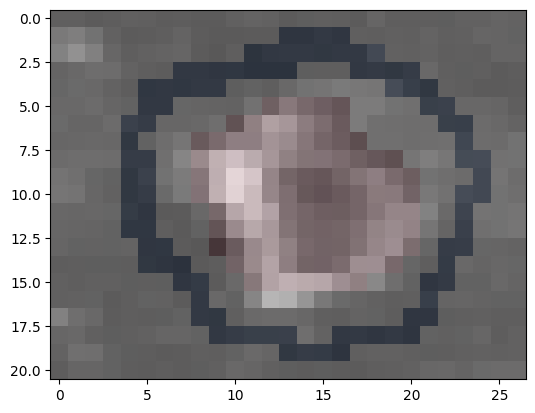

In [42]:
plt.imshow(cell1_data.max(axis=0), cmap='gray')
plt.imshow(cell1_mask, cmap='Reds', alpha=0.2)
plt.imshow(npil1_mask, cmap='Blues', alpha=0.2)

Plot `cell2` with cell and neuropil masks.

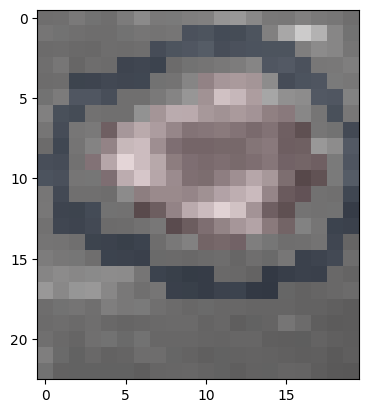

In [43]:
plt.imshow(cell2_data.max(axis=0), cmap='gray')
plt.imshow(cell2_mask, cmap='Reds', alpha=0.2)
plt.imshow(npil2_mask, cmap='Blues', alpha=0.2)

Plot `cell3` with cell and neuropil masks.

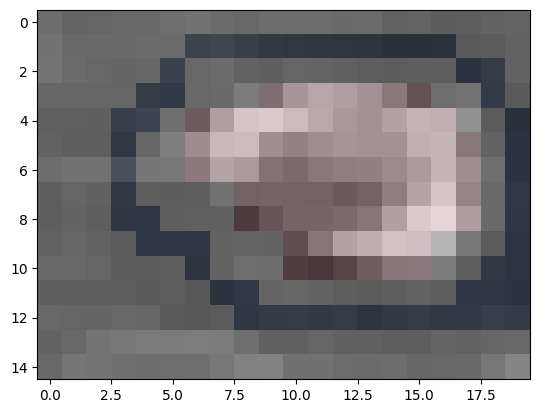

In [44]:
plt.imshow(cell3_data.max(axis=0), cmap='gray')
plt.imshow(cell3_mask, cmap='Reds', alpha=0.2)
plt.imshow(npil3_mask, cmap='Blues', alpha=0.2)

**Example** Extract average flourescence from `cell3`.

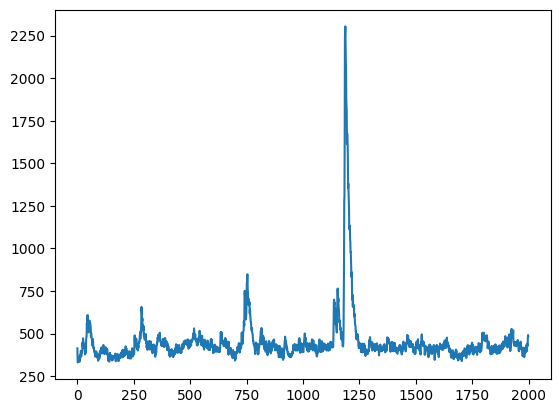

In [71]:
cmask = cell3_data * cell3_mask[np.newaxis, :, :] 
cell_trace3 = np.mean(cmask.reshape(cmask.shape[0], -1), axis=1)
plt.plot(cell_trace3)

Extract average flourescence from `cell2`

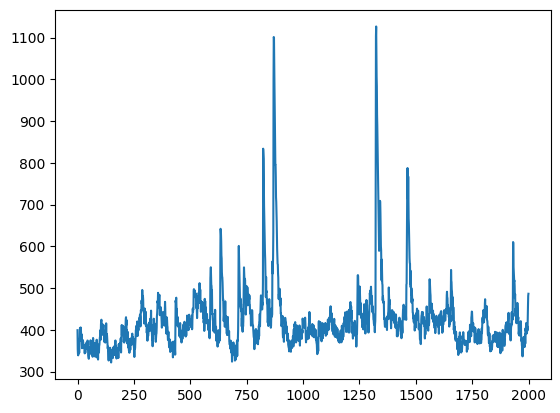

In [72]:
cmask = cell2_data * cell2_mask[np.newaxis, :, :] 
cell_trace2 = np.mean(cmask.reshape(cmask.shape[0], -1), axis=1)
plt.plot(cell_trace2)

Extract average flourescence from `cell3` and surrounding neuropil

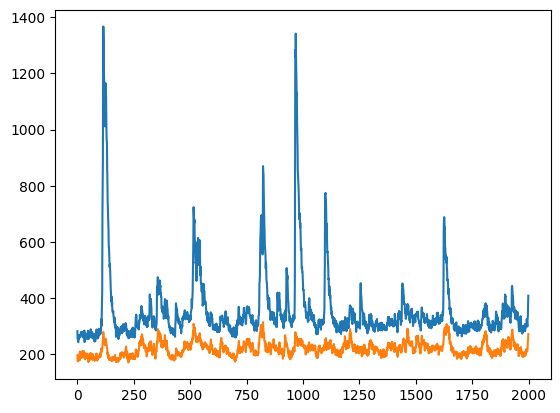

In [73]:
cmask = cell1_data * cell1_mask[np.newaxis, :, :] 
nmask = cell1_data * npil1_mask[np.newaxis, :, :]
cell_trace1 = np.mean(cmask.reshape(cmask.shape[0], -1), axis=1)
npil_trace1 = np.mean(nmask.reshape(cmask.shape[0], -1), axis=1)
plt.plot(cell_trace1)
plt.plot(npil_trace1)

**Example** Extract neuropil traces for `cell3` and `cell2`

In [74]:
nmask2 = cell2_data * npil2_mask[np.newaxis, :, :]
nmask3 = cell3_data * npil3_mask[np.newaxis, :, :]

npil_trace2 = np.mean(nmask2.reshape(cmask.shape[0], -1), axis=1)
npil_trace3 = np.mean(nmask3.reshape(cmask.shape[0], -1), axis=1)

Usually, neuropil trace is scaled by a factor of 0.7 before subtraction.

**Example** Plot neuropil subtracted calcium trace (`F1`) for `cell1` 

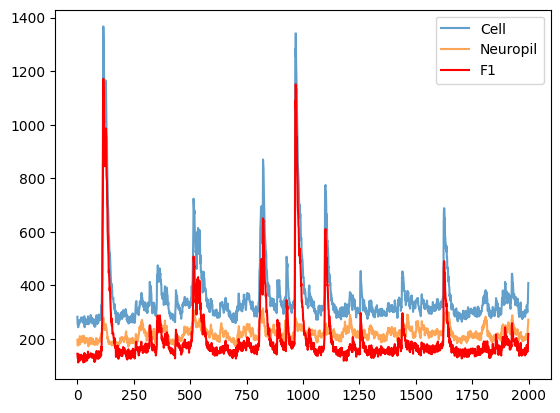

In [75]:
r = 0.7
F1 = cell_trace1 - r * npil_trace1

plt.plot(cell_trace1, alpha=0.7, label='Cell')
plt.plot(npil_trace1, alpha=0.7, label='Neuropil')
plt.plot(F1, color='red', label='F1')
plt.legend();

Plot neuropil subtracted calcium trace (`F2`) for `cell2`

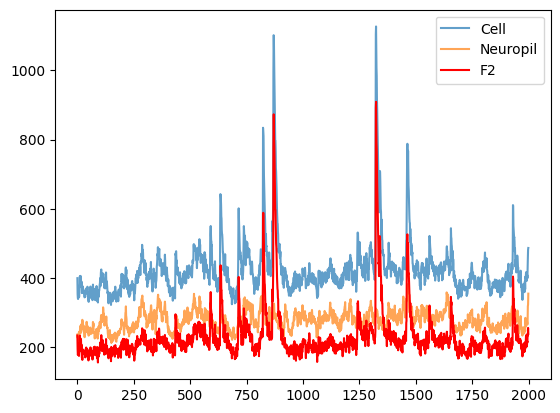

In [78]:
r = 0.7
F2 = cell_trace2 - r * npil_trace2

plt.plot(cell_trace2, alpha=0.7, label='Cell')
plt.plot(npil_trace2, alpha=0.7, label='Neuropil')
plt.plot(F2, color='red', label='F2')
plt.legend();

Plot neuropil subtracted calcium trace (`F3`) for `cell3`

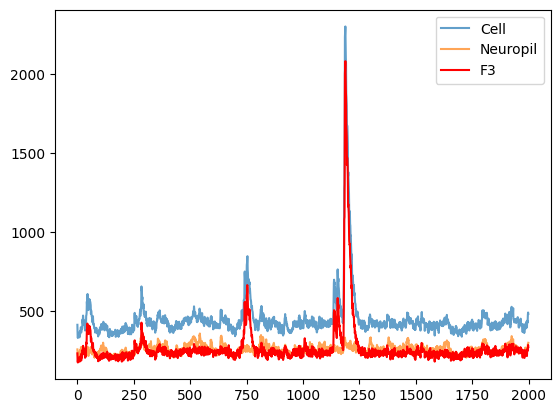

In [79]:
r = 0.7
F3 = cell_trace3 - r * npil_trace3

plt.plot(cell_trace3, alpha=0.7, label='Cell')
plt.plot(npil_trace3, alpha=0.7, label='Neuropil')
plt.plot(F3, color='red', label='F3')
plt.legend();

## **dF/F₀ Traces**

Estimating the baseline fluorescence (F₀) is the first step to producing dF/F₀ traces. In this section, you will explore three baseline estimation strategies first and then compute dF/F₀ from the estimated baselines.

**Example** Estimate baseline of `F1` using median.

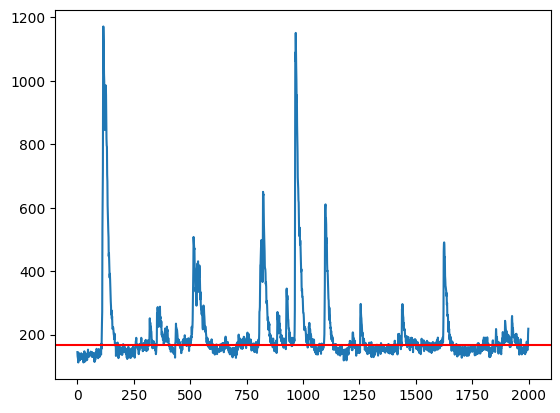

In [81]:
f0 = np.median(F1)
plt.plot(F1)
plt.axhline(f0, color='r')

Estimate baseline of `F2` using median.

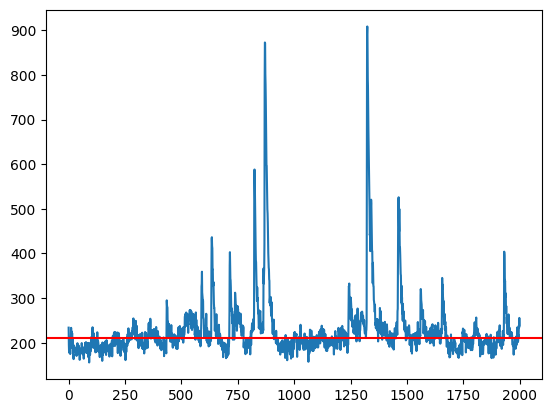

In [83]:
f0 = np.median(F2)
plt.plot(F2)
plt.axhline(f0, color='r')

Estimate baseline of `F3` with 20-percentile.

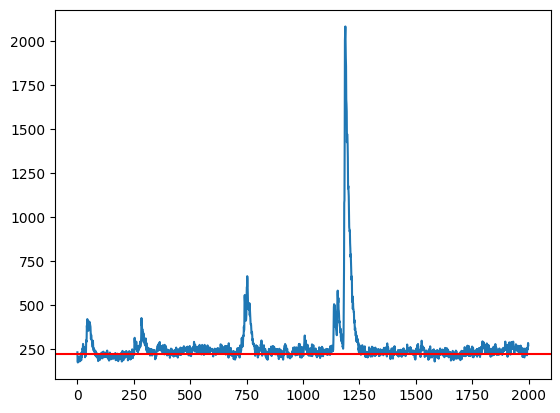

In [86]:
f0 = np.percentile(F3, 20)
plt.plot(F3)
plt.axhline(f0, color='r')

We can account for local changes in calcium trace by using moving windows. 

**Exercise** Apply a uniform filter for the rolling average for F1.

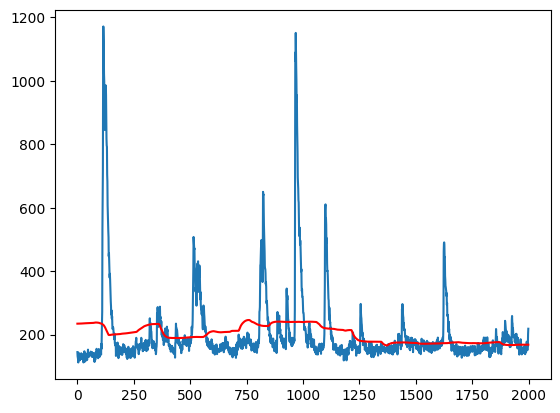

In [90]:
window_size = 500
f0 = uniform_filter1d(F1, size=window_size)

plt.plot(F1)
plt.plot(f0, color='r')

Apply a median filter for the rolling average for F1.

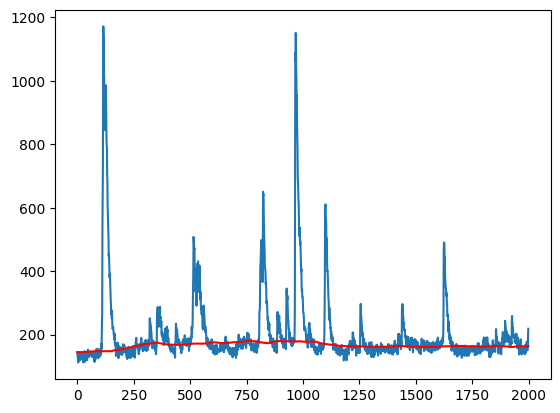

In [91]:
window_size = 500
f0 = median_filter(F1, size=window_size)

plt.plot(F1)
plt.plot(f0, color='r')

Apply a median filter for the rolling average for F2.

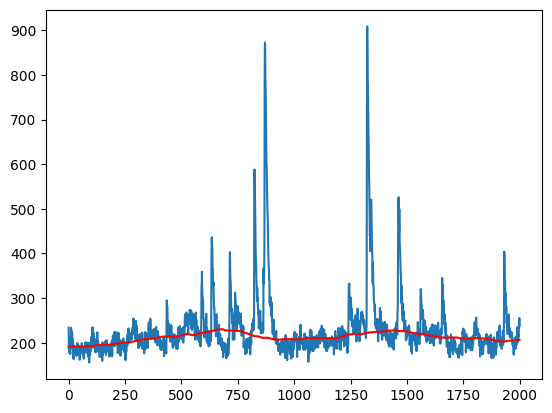

In [92]:
window_size = 500
f0 = median_filter(F2, size=window_size)

plt.plot(F2)
plt.plot(f0, color='r')

Apply a median filter for the rolling average for F3.

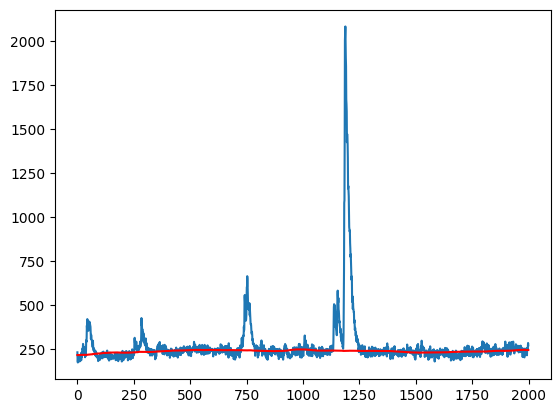

In [93]:
window_size = 500
f0 = median_filter(F3, size=window_size)

plt.plot(F3)
plt.plot(f0, color='r')

Now that we know how to estimate baseline, we can get our normalized calcium traces by simple subtraction and division operations of `numpy`.

**Example** Plot normalized calcium traces of `F1`.

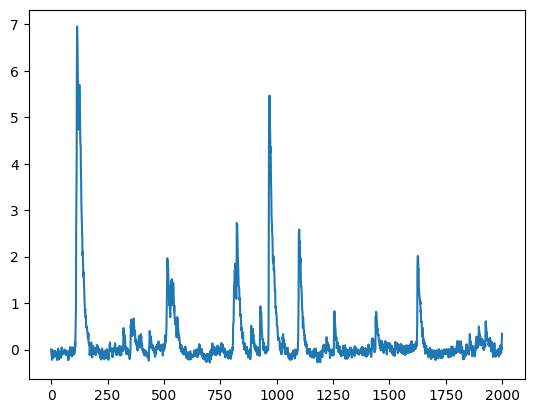

In [94]:
window_size = 500
f0 = median_filter(F1, size=window_size)
dff = (F1 - f0) / f0
plt.plot(dff)

Plot normalized calcium traces of `F2`.

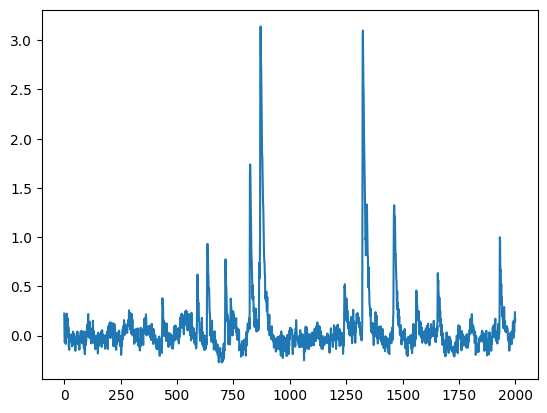

In [95]:
window_size = 500
f0 = median_filter(F2, size=window_size)
dff = (F2 - f0) / f0
plt.plot(dff)

Plot normalized calcium traces of `F3`.

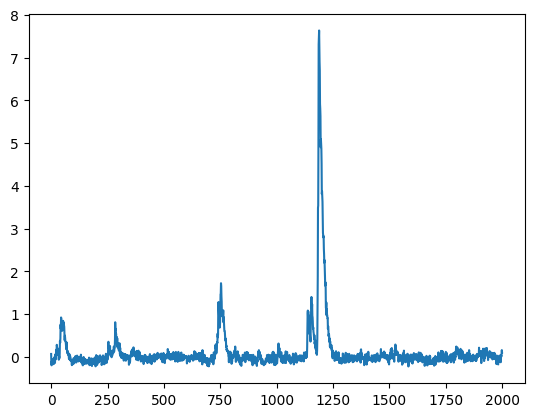

In [96]:
window_size = 500
f0 = median_filter(F3, size=window_size)
dff = (F3 - f0) / f0
plt.plot(dff)

## **Defining Cell and Neuropil Regions**

In the previous sections, we saw how to neuropil masks to an image to extract neuropil traces. In this section, you will use image processing tools from scikit-image to create, from the soma, a ring-shaped neuropil region. It has two main steps

- Dilate the cell mask outward using `disk(num_pixels)`. 
- Subtract the soma from the dilated mask.

**Example** Dilate the cell mask of `cell1`.

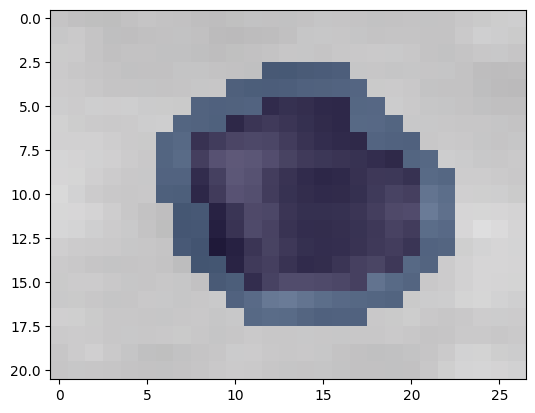

In [97]:
dilated_mask1 = dilation(cell1_mask, disk(2))
plt.imshow(cell1_data.mean(axis=0), cmap='gray')
plt.imshow(cell1_mask, cmap='Reds', alpha=0.5)
plt.imshow(dilated_mask1, cmap='Blues', alpha=0.5)

Dilate the cell mask of `cell2`.

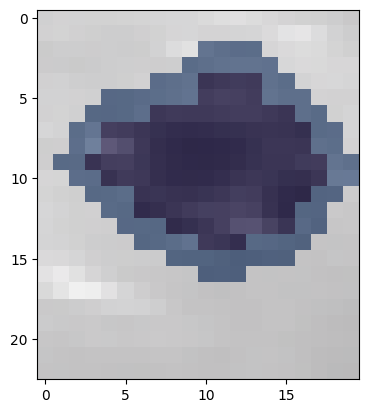

In [98]:
dilated_mask2 = dilation(cell2_mask, disk(2))
plt.imshow(cell2_data.mean(axis=0), cmap='gray')
plt.imshow(cell2_mask, cmap='Reds', alpha=0.5)
plt.imshow(dilated_mask2, cmap='Blues', alpha=0.5)

Dilate the cell mask of `cell3`.

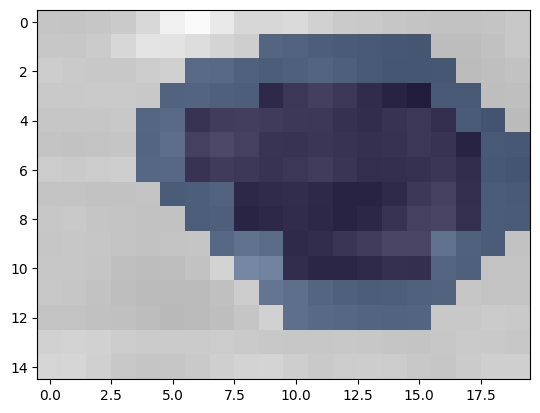

In [102]:
dilated_mask3 = dilation(cell3_mask, disk(2))
plt.imshow(cell3_data.mean(axis=0), cmap='gray')
plt.imshow(cell3_mask, cmap='Reds', alpha=0.5)
plt.imshow(dilated_mask3, cmap='Blues', alpha=0.5)

**Exercise** Subtract the soma to form a ring for `cell1`.

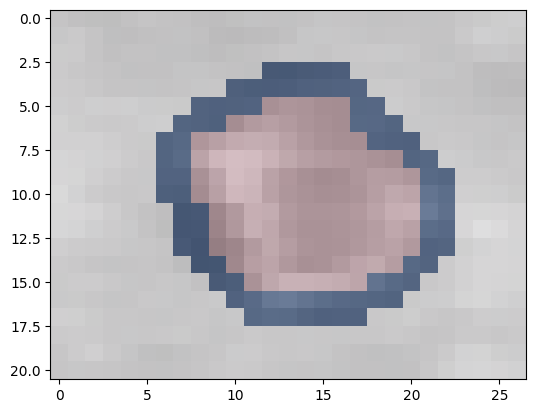

In [104]:
neuropil_mask1 = dilated_mask1 & (~cell1_mask)
plt.imshow(cell1_data.mean(axis=0), cmap='gray')
plt.imshow(cell1_mask, cmap='Reds', alpha=0.5)
plt.imshow(neuropil_mask1, cmap='Blues', alpha=0.5)

Subtract the soma to form a ring for `cell2`.

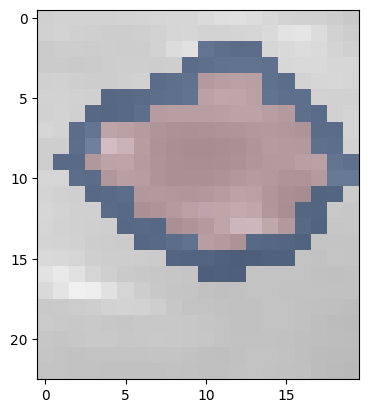

In [105]:
neuropil_mask2 = dilated_mask2 & (~cell2_mask)
plt.imshow(cell2_data.mean(axis=0), cmap='gray')
plt.imshow(cell2_mask, cmap='Reds', alpha=0.5)
plt.imshow(neuropil_mask2, cmap='Blues', alpha=0.5)

Subtract the soma to form a ring for `cell3`.

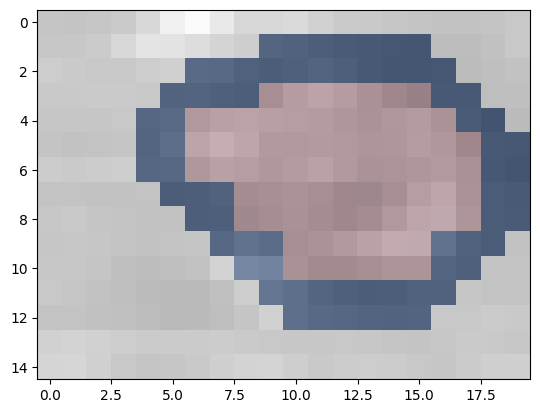

In [106]:
neuropil_mask3 = dilated_mask3 & (~cell3_mask)
plt.imshow(cell3_data.mean(axis=0), cmap='gray')
plt.imshow(cell3_mask, cmap='Reds', alpha=0.5)
plt.imshow(neuropil_mask3, cmap='Blues', alpha=0.5)